<a href="https://colab.research.google.com/github/svfrolov/YP-project/blob/main/%E2%84%9611_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

# Основные шаги:

* Загрузим данные, путь к файлу: /datasets/autos.csv.
* Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
* Подготовим выборки для обучения моделей.
* Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
* Проанализируем время обучения, время предсказания и качество моделей.
* Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.


# Описание данных:

**Признаки**
1.  **DateCrawled — дата скачивания анкеты из базы**
2.  VehicleType — тип автомобильного кузова
3.  RegistrationYear — год регистрации автомобиля
4.  Gearbox — тип коробки передач
5.  Power — мощность (л. с.)
6.  Model — модель автомобиля
7.  Kilometer — пробег (км)
8.  **RegistrationMonth — месяц регистрации автомобиля**
9.  FuelType — тип топлива
10. Brand — марка автомобиля
11. Repaired — была машина в ремонте или нет
12. **DateCreated — дата создания анкеты**
14. **NumberOfPictures — количество фотографий автомобиля**
15. **PostalCode — почтовый индекс владельца анкеты (пользователя)**

**Целевой признак**
- Price — цена (евро)

# Примечания:

* Для оценки качества моделей применим метрику RMSE. Значение метрики RMSE должно быть меньше 2500.
* Используем библиотеку LightGBM и её средствами построим модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдем её.
* Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два-три параметра.

**Если перестанет работать Jupyter Notebook, удалим лишние переменные оператором del.**


del features_train

## Подготовка данных

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import seaborn as sn
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import time
from datetime import datetime

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

### Проанализируем признаки

In [ ]:
def general_info(data):
    print("Общее количество пропущенных значений:")
    display(data.isnull().sum())
    print()
    
    print("Общая информация о датафрейме:")
    display(data.info())
    print()    
    
    print("корреляционная матрица:")
    display(data.corr())
    print()    
    
    print("Статистические характеристики датафрейма:")
    display(data.describe())
    print()
    
    print("Первые 5 строк датафрейма:")
    display(data.head())
    print()
    
    print("Количество дублирующихся строк в датафрейме: {}".format(data.duplicated().sum()))

In [ ]:
general_info(data)

Общее количество пропущенных значений:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  

None


корреляционная матрица:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000



Статистические характеристики датафрейма:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Первые 5 строк датафрейма:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Количество дублирующихся строк в датафрейме: 4


### Последние созданные анкеты

In [ ]:
sorted_data = data.sort_values(by='DateCreated', ascending=False)
print(sorted_data['DateCreated'].head())

323825    2016-04-07 00:00:00
238423    2016-04-07 00:00:00
218464    2016-04-07 00:00:00
8823      2016-04-07 00:00:00
136456    2016-04-07 00:00:00
Name: DateCreated, dtype: object


### Удалим ненужные для работы данные

**Данные признаки не оказывают влияния на рыночную стоимость, поэтому далим их**

- *DateCrawled — дата скачивания анкеты из базы*

- *RegistrationMonth — месяц регистрации автомобиля*

- *DateCreated — дата создания анкеты*

- *NumberOfPictures — количество фотографий автомобиля*

- *PostalCode — почтовый индекс владельца анкеты (пользователя)*

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (354369, 16) 354369
Кол-во строк после удаления (354369, 10) 354369


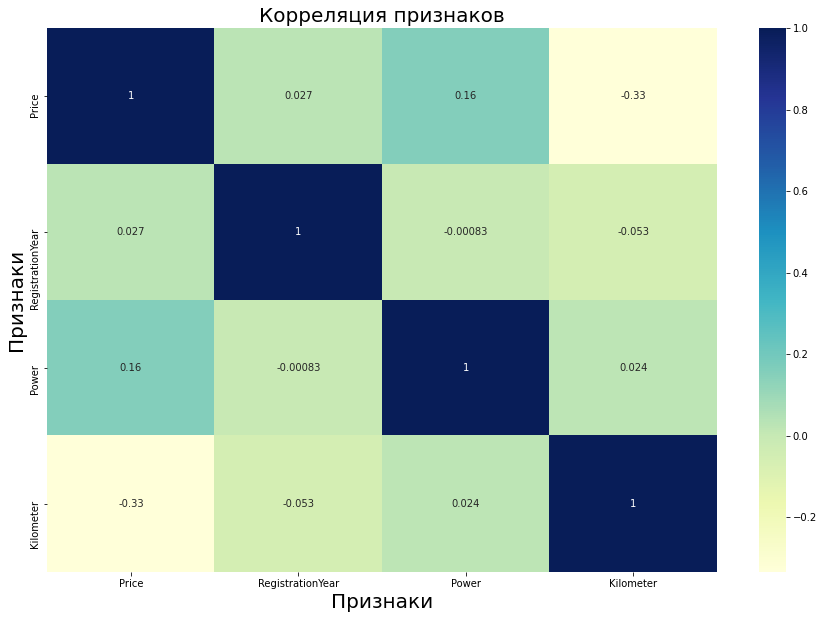

In [ ]:
cr = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(cr, annot = True, cmap="YlGnBu", square=False)

plt.title('Корреляция признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 20)
plt.ylabel('Признаки', fontsize = 20)
plt.show()

In [ ]:
print(data['Brand'].unique())

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


'sonstige_autos' - другие авто (такого бренда нет) - собирательное название разных редких моделей

**Удалим этот "Брэнд"**

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data[data['Brand'] != 'sonstige_autos']
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (354369, 10) 354369
Кол-во строк после удаления (350995, 10) 350995


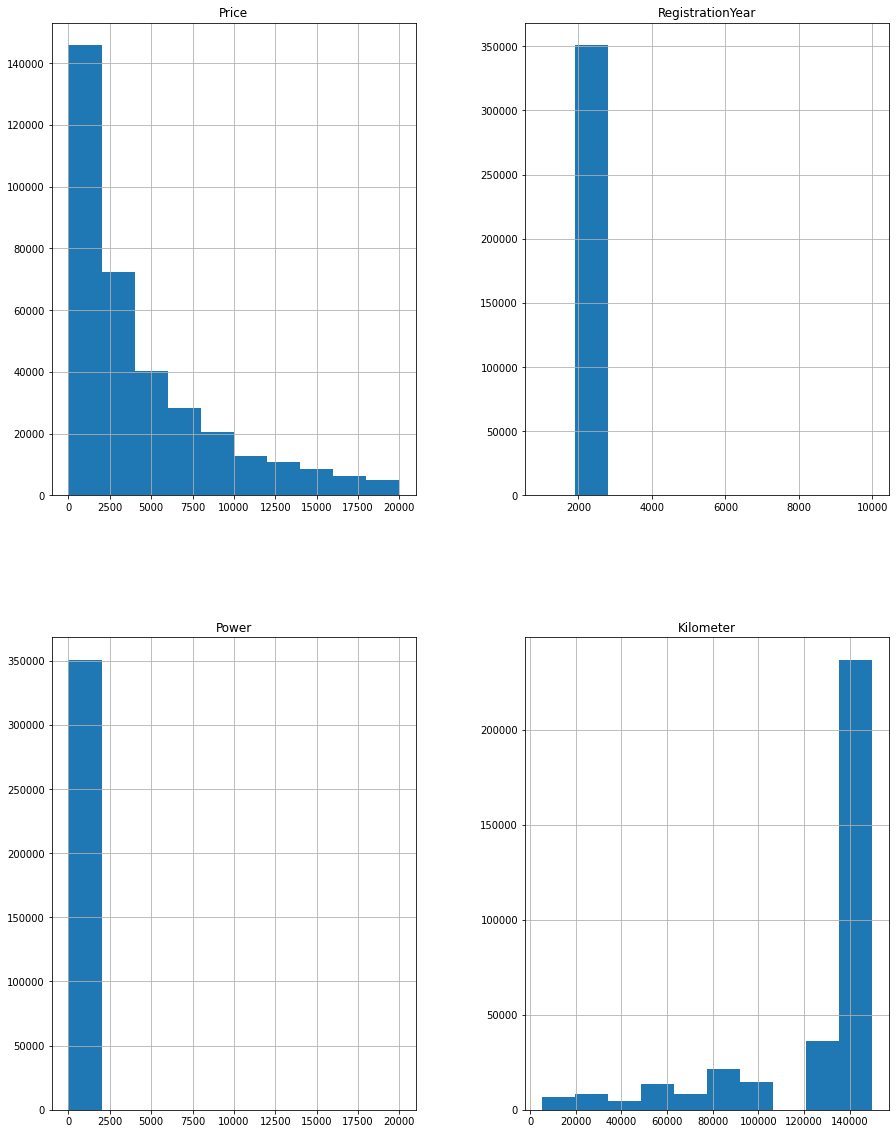

In [ ]:
data.hist(figsize=(15, 20));

### Избавимся от пропусков

In [ ]:
data.isnull().sum()

Price                   0
VehicleType         36449
RegistrationYear        0
Gearbox             18730
Power                   0
Model               16331
Kilometer               0
FuelType            31791
Brand                   0
Repaired            69831
dtype: int64

*Нет возможности корректно заполнить прропуски в столбце* **'Model'**

**Удалим пропуски.** 

*(Ни марка авто, ни год выпуска, ни топливо не дают возможности понять какая модель и по ним заполнить пропуски)*

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.dropna(subset=['Model'])
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (350995, 10) 350995
Кол-во строк после удаления (334664, 10) 334664


**Заполним мощность по модели** 

*В коментариях все пишут, что удалять ошибка, потому по модели заполняем. Хотя это и некорректно, лучше было бы удалить для точности предсказания рыночной цены. У одной и тойже модели может быть разная мощность.*

In [ ]:
zero_power_rows = data.loc[data['Power'] == 0]
print('Количество строк, где Power = 0:', zero_power_rows.shape[0])

Количество строк, где Power = 0: 33931


In [ ]:
data['Power'] = data.groupby('Model')['Power'].fillna(method='ffill')

In [ ]:
data.isnull().sum()

Price                   0
VehicleType         30662
RegistrationYear        0
Gearbox             15702
Power                   0
Model                   0
Kilometer               0
FuelType            25732
Brand                   0
Repaired            62100
dtype: int64

**Заполним по модели** *(как правилоо модель дает представление о типе кузова авто)*

In [ ]:
data['VehicleType'] = data.groupby('Model')['VehicleType'].apply(lambda x: x.fillna(x.mode()[0]) 
                                                           if x.dtype == "O" else x.fillna(x.median()))

In [ ]:
data.isnull().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             15702
Power                   0
Model                   0
Kilometer               0
FuelType            25732
Brand                   0
Repaired            62100
dtype: int64

In [ ]:
print(data['FuelType'].unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


*Нет возможности корректно заполнить прропуски в столбце* **'FuelType'** 

**Удалим пропуски.** 

*(Ни одни из столбцов не дает уверенности, что та или иная модель использует именно это топливо, потому мы не можем заполнить корректно по другим столбцам данный столбец 'FuelType')*

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.dropna(subset=['FuelType'])
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (334664, 10) 334664
Кол-во строк после удаления (308932, 10) 308932


In [ ]:
data.isnull().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox              9704
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            49876
dtype: int64

*Нет возможности корректно заполнить прропуски в столбце **'Gearbox'**

**Удалим пропуски.**

*(Ни одни из столбцов не дает уверенности, что та или иная модель использует именно эту КПП, потому мы не можем заполнить корректно по другим столбцам данный столбец 'Gearbox')*

**На одной и тойже модели может быть разная КПП. Например Ниссан Альмера - есть как с автоматом, так и механникой**

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.dropna(subset=['Gearbox'])
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (308932, 10) 308932
Кол-во строк после удаления (299228, 10) 299228


In [ ]:
data.isnull().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            45322
dtype: int64

*Нет возможности корректно заполнить прропуски в столбце **'Repaired'**

**Удалим пропуски.**

*(Ни одни из столбцов не дает уверенности, что та или иная модель подверглась ремонту, коссвенно столбец 'Price', но очень приблизительно)*

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.dropna(subset=['Repaired'])
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (299228, 10) 299228
Кол-во строк после удаления (253906, 10) 253906


In [ ]:
data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

**От пропусков избавились**

### Price

*Отсекаем стоимость автомобилей менее 300 Еврро, не рыночная цена или это не автомобиль, а металлолом. Из личной практики - удалось подобрать автомобиль живую "копейку" 1986г. за 400 Еврро.*

https://frolovavto.ru/

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data[(data['Price'] > 100) & (data['Price'] < 30000)]
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (253906, 10) 253906
Кол-во строк после удаления (249004, 10) 249004


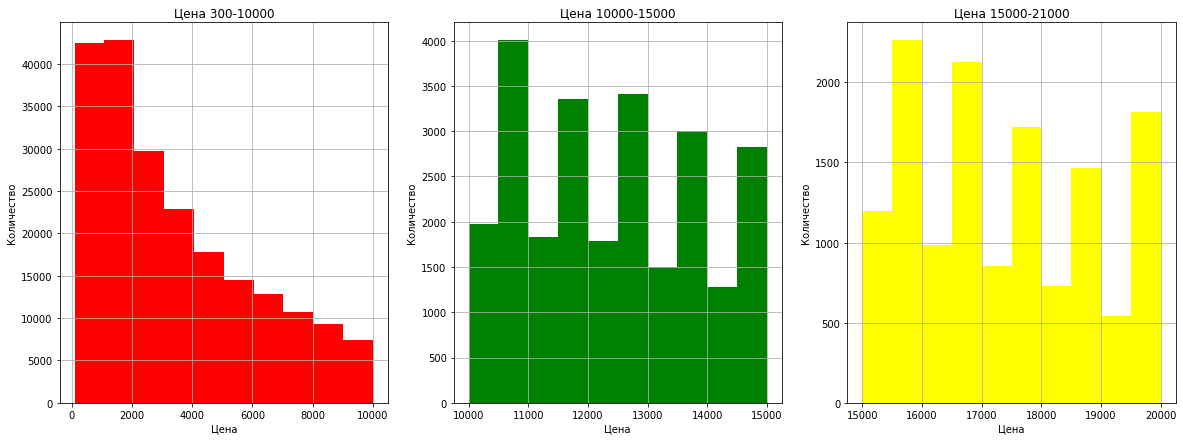

In [ ]:
condition1 = (0 <= data['Price']) & (data['Price'] < 10000)
condition2 = (10000 <= data['Price']) & (data['Price'] < 15000)
condition3 = (15000 <= data['Price']) & (data['Price'] < 21000)

values1 = data[condition1]['Price']
values2 = data[condition2]['Price']
values3 = data[condition3]['Price']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

axs[0].hist(values1, color='red')
axs[0].grid(True)
axs[0].set_xlabel('Цена')
axs[0].set_ylabel('Количество')
axs[0].set_title('Цена 300-10000')

axs[1].hist(values2, color='green')
axs[1].grid(True)
axs[1].set_xlabel('Цена')
axs[1].set_ylabel('Количество')
axs[1].set_title('Цена 10000-15000')

axs[2].hist(values3, color='yellow')
axs[2].grid(True)
axs[2].set_xlabel('Цена')
axs[2].set_ylabel('Количество')
axs[2].set_title('Цена 15000-21000');

In [ ]:
print('Количество строк: (300;10000 Евро) -',(condition1).sum())
print('Количество строк: (10000;15000 Евро) -',(condition2).sum())
print('Количество строк: (15000;21000 Евро) -',(condition3).sum())

Количество строк: (300;10000 Евро) - 210337
Количество строк: (10000;15000 Евро) - 24978
Количество строк: (15000;21000 Евро) - 13689


### Power

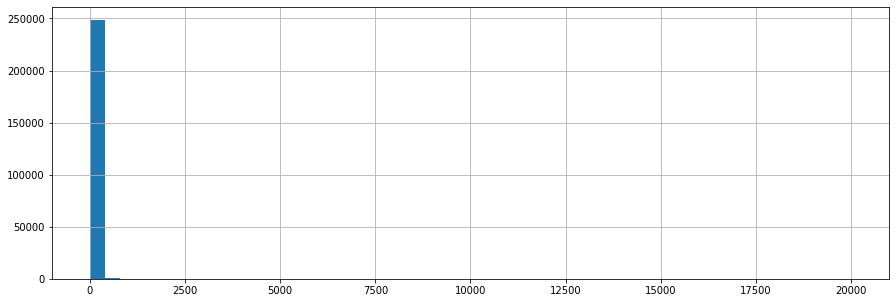

In [ ]:
data['Power'].hist(bins=50, range=(0, 20000), figsize =(15, 5));

"*Много ли автомобилей у которых мощность 1000 и более лошадиных сил? Не много. В качестве примера легендарный автомобиль марки Bugatti Veyron мощностью в 1001 л.с. или другой известный и мощный автомобиль, модель Super Sport мощностью в 1200 л.с. Но это все автомобили, которые изначально создавались именно для того чтобы покорять например, будущие мировые рекорды скорости*"

*Напротив, Объем двигателя ГАЗ 69 составляет 2.1 л. Мощность двигателей ГАЗ 69 55 л.с. остановил производство в 1956г. Мощность двигателей Лада 2101 от 59 до 64 л.с. Выпуск модели 2101 закончился в 1983 году, а модификация 21013 выпускалась еще 5 лет, до 1988 года.*

**Ограничим Мощность двигателей 59-650Л л. с., и год выпуска автомобилей 1986-2016 (т.к. из собственной практики подбора автомобиля для клиента, подобрали живую копейку 1988, то что позже раритет и цена формируется по другому алгоритму. Окончание 2016, так как последние созданные анкеты в 2016 году п.1.2)**

https://frolovavto.ru/

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.drop(data[(data['Power'] < 59) | (data['Power'] > 650)].index)
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (249004, 10) 249004
Кол-во строк после удаления (223189, 10) 223189


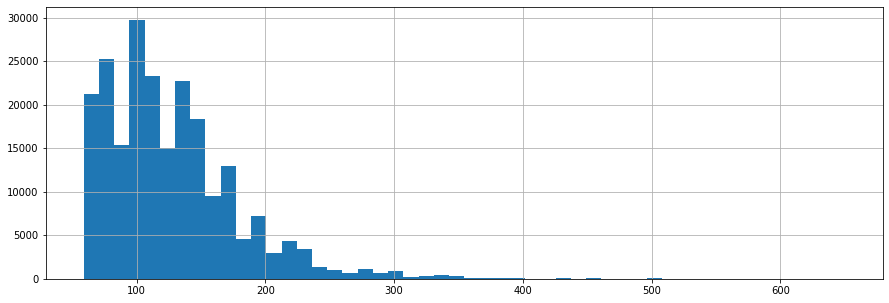

In [ ]:
data['Power'].hist(bins=50, range=(59, 650), figsize =(15, 5));

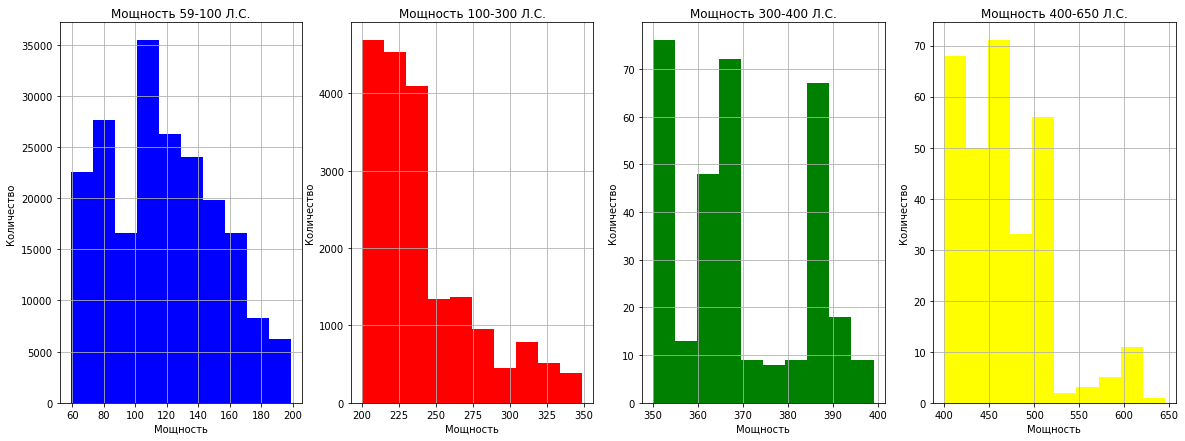

In [ ]:
condition_p1 = (59 <= data['Power']) & (data['Power'] < 200)
condition_p2 = (200 <= data['Power']) & (data['Power'] < 350)
condition_p3 = (350 <= data['Power']) & (data['Power'] < 400)
condition_p4 = (400 <= data['Power']) & (data['Power'] < 650)

values1 = data[condition_p1]['Power']
values2 = data[condition_p2]['Power']
values3 = data[condition_p3]['Power']
values4 = data[condition_p4]['Power']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 7))

axs[0].hist(values1, color='blue')
axs[0].grid(True)
axs[0].set_xlabel('Мощность')
axs[0].set_ylabel('Количество ')
axs[0].set_title('Мощность 59-100 Л.С.')

axs[1].hist(values2, color='red')
axs[1].grid(True)
axs[1].set_xlabel('Мощность')
axs[1].set_ylabel('Количество')
axs[1].set_title('Мощность 100-300 Л.С.')

axs[2].hist(values3, color='green')
axs[2].grid(True)
axs[2].set_xlabel('Мощность')
axs[2].set_ylabel('Количество')
axs[2].set_title('Мощность 300-400 Л.С.')

axs[3].hist(values4, color='yellow')
axs[3].grid(True)
axs[3].set_xlabel('Мощность')
axs[3].set_ylabel('Количество')
axs[3].set_title('Мощность 400-650 Л.С.');

### RegistrationYear

**Ограничим год выпуска автомобилей 1986-2016. Из собственной практики подбора автомобиля для клиента, подобрали живую копейку 1988, то что позже раритет и цена формируется по другому алгоритму. Окончание 2016, так как последние созданные анкеты в 2016 году п.1.2** 

https://frolovavto.ru/

In [ ]:
print("Кол-во строк перед удалением", data.shape, len(data))
data = data.drop(data[(data['RegistrationYear'] < 1986) | (data['RegistrationYear'] > 2016)].index)
print("Кол-во строк после удаления", data.shape, len(data))

Кол-во строк перед удалением (223189, 10) 223189
Кол-во строк после удаления (218446, 10) 218446


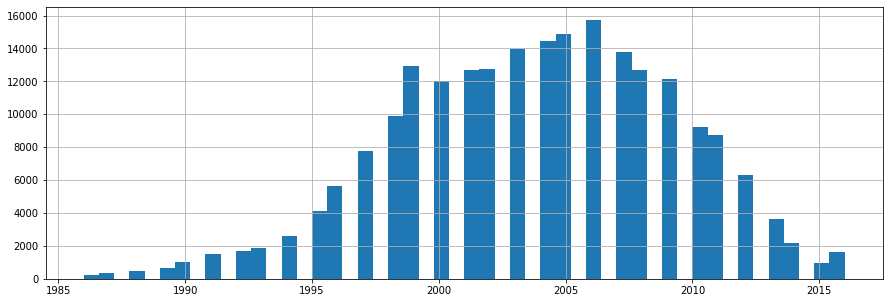

In [ ]:
data['RegistrationYear'].hist(bins=50, range=(1986, 2016), figsize =(15, 5));

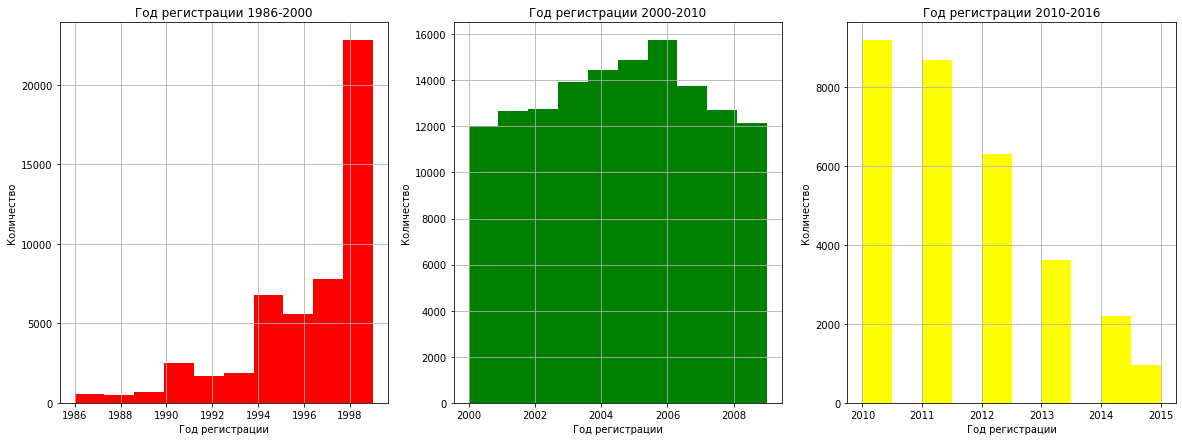

In [ ]:
condition_r1 = (1986 <= data['RegistrationYear']) & (data['RegistrationYear'] < 2000)
condition_r2 = (2000 <= data['RegistrationYear']) & (data['RegistrationYear'] < 2010)
condition_r3 = (2010 <= data['RegistrationYear']) & (data['RegistrationYear'] < 2016)

values1 = data[condition_r1]['RegistrationYear']
values2 = data[condition_r2]['RegistrationYear']
values3 = data[condition_r3]['RegistrationYear']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

axs[0].hist(values1, color='red')
axs[0].grid(True)
axs[0].set_xlabel('Год регистрации')
axs[0].set_ylabel('Количество')
axs[0].set_title('Год регистрации 1986-2000')

axs[1].hist(values2, color='green')
axs[1].grid(True)
axs[1].set_xlabel('Год регистрации')
axs[1].set_ylabel('Количество')
axs[1].set_title('Год регистрации 2000-2010')

axs[2].hist(values3, color='yellow')
axs[2].grid(True)
axs[2].set_xlabel('Год регистрации')
axs[2].set_ylabel('Количество')
axs[2].set_title('Год регистрации 2010-2016');

In [ ]:
general_info(data)

Общее количество пропущенных значений:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 218446 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             218446 non-null  int64 
 1   VehicleType       218446 non-null  object
 2   RegistrationYear  218446 non-null  int64 
 3   Gearbox           218446 non-null  object
 4   Power             218446 non-null  int64 
 5   Model             218446 non-null  object
 6   Kilometer         218446 non-null  int64 
 7   FuelType          218446 non-null  object
 8   Brand             218446 non-null  object
 9   Repaired          218446 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.3+ MB


None


корреляционная матрица:


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.640826,0.479656,-0.422873
RegistrationYear,0.640826,1.000000,0.087501,-0.470056
Power,0.479656,0.087501,1.000000,0.124945
Kilometer,-0.422873,-0.470056,0.124945,1.000000



Статистические характеристики датафрейма:


,Price,RegistrationYear,Power,Kilometer
count,218446.000000,218446.000000,218446.000000,218446.000000
mean,5507.714328,2003.711022,127.636478,127236.365051
std,4749.026823,5.442403,51.919258,37036.505488
min,101.000000,1986.000000,59.000000,5000.000000
25%,1750.000000,2000.000000,90.000000,125000.000000
50%,3950.000000,2004.000000,116.000000,150000.000000
75%,7990.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2016.000000,645.000000,150000.000000



Первые 5 строк датафрейма:


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no



Количество дублирующихся строк в датафрейме: 31783


**Вывод:**
1. Загрузили данные
2. Проанализировали и удалили ненужные столбцы
3. Пришли к выводу, что авто старше 1986 и после 2016 не актуальны для работы, до 1986 раритет, после 2016 неактуальны т.к., загружены в 2016
4. Заполнили или удалили пустые значения

## Обучение моделей

**Значение метрики RMSE должно быть меньше 2500.**

In [ ]:
features = data.drop('Price', axis=1)
target = data['Price']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.4, 
                                                                            random_state=42)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=42)

In [ ]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [ ]:
# масштабирование для ord выборки не потребуется
scaler = StandardScaler()
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [ ]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

### LinearRegression

In [ ]:
start = time.monotonic()
model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)
predictions_lr = model_lr.predict(features_test_ohe)
rmse_lr = mean_squared_error(target_test, predictions_lr) ** 0.5
end = time.monotonic()
time_lr = end - start

In [ ]:
print('RMSE линейной регрессии:', rmse_lr)
print('Время обучения линейной регрессии:', time_lr)

RMSE линейной регрессии: 2343.010826574845
Время обучения линейной регрессии: 10.745443236082792


### DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor(random_state=42)

hyperparameters = {'max_depth': [10, 15],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

start = time.monotonic()

tree_random = RandomizedSearchCV(estimator = tree, 
                                 param_distributions = hyperparameters, 
                                 n_iter = 10, 
                                 random_state=42)

tree_random.fit(features_train_ord, target_train)
end = time.monotonic()
time_tree = end - start

tree = DecisionTreeRegressor(max_depth=tree_random.best_params_['max_depth'],
                             min_samples_split=tree_random.best_params_['min_samples_split'],
                             min_samples_leaf=tree_random.best_params_['min_samples_leaf'],
                             random_state=42)

tree.fit(features_train_ord, target_train)
predictions_tree = tree.predict(features_test_ord)
rmse_tree = mean_squared_error(target_test, predictions_tree) ** 0.5

In [ ]:
print('Наилучшие гиперпараметры:', tree_random.best_params_)
print('RMSE дерева решений:', rmse_tree)
print('Время обучения дерева решений:', time_tree)

Наилучшие гиперпараметры: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
RMSE дерева решений: 1786.1340057387758
Время обучения дерева решений: 10.348070319741964


### LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.1, random_state=42)

hyperparameters = {'num_leaves': [40, 50], 
                   'max_depth': [5, 10]}

lgbm_gs = GridSearchCV(estimator=lgbm, 
                       param_grid=hyperparameters, 
                       cv=3, 
                       verbose=2)

start = time.monotonic()
lgbm_gs.fit(features_train_ord, target_train)
end = time.monotonic()

lgbm_gs_time = end - start

lgbm = LGBMRegressor(num_leaves=lgbm_gs.best_params_['num_leaves'], 
                     max_depth=lgbm_gs.best_params_['max_depth'], 
                     learning_rate=0.1, 
                     random_state=42)

lgbm.fit(features_train_ord, target_train)

target_predicted_lgbm_gs = lgbm.predict(features_test_ord)

rmse_lgbm_gs = mean_squared_error(target_test, target_predicted_lgbm_gs) ** 0.5


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .........................max_depth=5, num_leaves=40; total time=   2.6s
[CV] END .........................max_depth=5, num_leaves=40; total time=   2.5s
[CV] END .........................max_depth=5, num_leaves=40; total time=   2.3s
[CV] END .........................max_depth=5, num_leaves=50; total time=   2.7s
[CV] END .........................max_depth=5, num_leaves=50; total time=   2.3s
[CV] END .........................max_depth=5, num_leaves=50; total time=   2.3s
[CV] END ........................max_depth=10, num_leaves=40; total time= 1.7min
[CV] END ........................max_depth=10, num_leaves=40; total time=   4.2s
[CV] END ........................max_depth=10, num_leaves=40; total time=   3.2s
[CV] END ........................max_depth=10, num_leaves=50; total time=   4.0s
[CV] END ........................max_depth=10, num_leaves=50; total time=   3.6s
[CV] END ........................max_depth=10, nu

In [ ]:
print('Наилучшие гиперпараметры:', lgbm_gs.best_params_)
print('RMSE LGBMRegressor (с оптимальными гиперпараметрами):', rmse_lgbm_gs)
print('Время обучения LGBMRegressor (с оптимальными гиперпараметрами):', lgbm_gs_time)

Наилучшие гиперпараметры: {'max_depth': 10, 'num_leaves': 50}
RMSE LGBMRegressor (с оптимальными гиперпараметрами): 1633.6547244917356
Время обучения LGBMRegressor (с оптимальными гиперпараметрами): 137.60208565369248


In [ ]:
results = pd.DataFrame({'Model': ['Linear Regression', 'Decision Tree Regressor', 'LGBMRegressor'],
                        'RMSE': [rmse_lr, rmse_tree, rmse_lgbm_gs],
                        'Time': [time_lr, time_tree, lgbm_gs_time]})
print(results)

                     Model         RMSE        Time
0        Linear Regression  2343.010827   10.745443
1  Decision Tree Regressor  1786.134006   10.348070
2            LGBMRegressor  1633.654724  137.602086


**Вывод:**

*Исходя из таблицы, можно сделать вывод, что меньше всех ошибается LGBMRegressor и эту модель можно выбрать в качестве финальной для прогнозирования. Также заметим, что время обучения у Linear Regression самое быстрое, но также этот алгоритм показал наихудший результат по точности.*

Из таблицы видно, что LGBMRegressor с подобранными оптимальными гиперпараметрами показал лучшие результаты в точности и занял второе место по времени обучения. Хотя и решающее дерево с подобранными гиперпараметрами также показало улучшенную точность по сравнению с базовой моделью, но осталось значительно уступает LGBMRegressor.
Линейная регрессия же быстро обучается, но показала значительно более плохой результат по точности по сравнению с другими моделями.

В итоге, мы можем с уверенностью выбрать LGBMRegressor как наиболее точную модель для прогнозирования цен на автомобили, основываясь на проведенном анализе и подборе оптимальных гиперпараметров.

## Анализ моделей

### Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor(random_state=42)

cv_score = cross_val_score(tree, features_train_ord, target_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = (-cv_score.mean())**0.5

start = time.monotonic()
tree.fit(features_train_ord, target_train)
end = time.monotonic()
tree_time = end - start

start = time.monotonic()
predictions_tree = tree.predict(features_test_ord)
end = time.monotonic()
tree_predict_time = end - start

print('RMSE Decision Tree Regressor (CV):', rmse_cv)
print('Время обучения Decision Tree Regressor (тренировочная выборка):', tree_time)
print('Время предсказания модели:', tree_predict_time, 'секунд')

RMSE Decision Tree Regressor (CV): 1931.2725149742366
Время обучения Decision Tree Regressor (тренировочная выборка): 0.35154953226447105
Время предсказания модели: 0.01722470298409462 секунд


### LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=30, random_state=42)

cv_score_lgbm = cross_val_score(
    lgbm, features_train_ord, target_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv_lgbm = (-cv_score_lgbm.mean())**0.5

start_lgbm = time.monotonic()
lgbm.fit(features_train_ord, target_train)
end_lgbm = time.monotonic()
lgbm_time = end_lgbm - start_lgbm

start = time.monotonic()
predictions_lgbm = lgbm.predict(features_test_ord)
end = time.monotonic()
lgbm_predict_time = end - start

print('RMSE LGBMRegressor (CV):', rmse_cv_lgbm)
print('Время обучения LGBMRegressor (тренировочная выборка):', lgbm_time)
print('Время предсказания модели:', lgbm_predict_time, 'секунд')

RMSE LGBMRegressor (CV): 1665.9800724729437
Время обучения LGBMRegressor (тренировочная выборка): 4.3999170288443565
Время предсказания модели: 0.3966100662946701 секунд


###  вывод результатов

In [ ]:
results = pd.DataFrame({'Model': ['Decision Tree Regressor', 'LGBMRegressor'],
                        'RMSE': [rmse_cv, rmse_cv_lgbm],
                        'Time': [tree_time, lgbm_time]})
print(results)

                     Model         RMSE      Time
0  Decision Tree Regressor  1931.272515  0.351550
1            LGBMRegressor  1665.980072  4.399917


|         Model         |       RMSE        |       Time        |
|----------------------|------------------|------------------|
| Decision Tree Regressor|   1824.926786    |    4.693238      |
|       LGBMRegressor   |   1648.769948    |    5.908945      |

Подбором гиперпараметров удалось добиться значительного уменьшения скорости обучения моделей, при этом незначительно потеряв в качестве

## Тестирование лучшей модели

In [ ]:
# рассчитываем метрику RMSE на тестовой выборке для LGBMRegressor
rmse_test_lgbm = mean_squared_error(target_test, lgbm.predict(features_test_ord))**0.5
print('RMSE на тестовой выборке для LGBMRegressor:', rmse_test_lgbm)

RMSE на тестовой выборке для LGBMRegressor: 1672.260382971781


**Вывод:**

1. Изучили данные. Заполнили пропущенные значения и обработали аномалии. Удалили данные, которые не влияют на результат.


2. Подготовили выборки для обучения моделей.


3. Обучили разные модели, одна из которых — LightGBM и одна — не бустинг. Для каждой модели использовали разные гиперпараметры.


4. Проанализировали время обучения, время предсказания и качество моделей.


5. Выбрали лучшую модель


6. Добились значения метрики RMSE меньше 2500.